# Structured and time series data

This notebook contains an implementation of the third place result in the Rossman Kaggle competition as detailed in Guo/Berkhahn's [Entity Embeddings of Categorical Variables](https://arxiv.org/abs/1604.06737).

The motivation behind exploring this architecture is it's relevance to real-world application. Most data used for decision making day-to-day in industry is structured and/or time-series data. Here we explore the end-to-end process of using neural networks with practical structured data problems.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

PATH='rossmann/'

## Create datasets

In addition to the provided data, we will be using external datasets put together by participants in the Kaggle competition. You can download all of them [here](http://files.fast.ai/part2/lesson14/rossmann.tgz).

For completeness, the implementation used to put them together is included below.

In [4]:
def concat_csvs(dirname):
    path = f'{PATH}{dirname}'
    filenames=glob.glob(f"{path}/*.csv")

    wrote_header = False
    with open(f"{path}.csv","w") as outputfile:
        for filename in filenames:
            name = filename.split(".")[0]
            with open(filename) as f:
                line = f.readline()
                if not wrote_header:
                    wrote_header = True
                    outputfile.write("file,"+line)
                for line in f:
                     outputfile.write(name + "," + line)
                outputfile.write("\n")

In [5]:
# concat_csvs('googletrend')
# concat_csvs('weather')

Feature Space:
* train: Training set provided by competition
* store: List of stores
* store_states: mapping of store to the German state they are in
* List of German state names
* googletrend: trend of certain google keywords over time, found by users to correlate well w/ given data
* weather: weather
* test: testing set

In [6]:
table_names = ['train', 'store', 'store_states', 'state_names', 
               'googletrend', 'weather', 'test']

We'll be using the popular data manipulation framework `pandas`. Among other things, pandas allows you to manipulate tables/data frames in python as one would in a database.

We're going to go ahead and load all of our csv's as dataframes into the list `tables`.

In [10]:
tables = [pd.read_csv(f'{PATH}{fname}.csv', low_memory=False) for fname in table_names]

In [11]:
from IPython.display import display, HTML

We can use `head()` to get a quick look at the contents of each table:
* train: Contains store information on a daily basis, tracks things like sales, customers, whether that day was a holdiay, etc.
* store: general info about the store including competition, etc.
* store_states: maps store to state it is in
* state_names: Maps state abbreviations to names
* googletrend: trend data for particular week/state
* weather: weather conditions for each state
* test: Same as training table, w/o sales and customers


In [12]:
for t in tables: display(t.head())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


,Store,State
0,1,HE
1,2,TH
2,3,NW
3,4,BE
4,5,SN


,StateName,State
0,BadenWuerttemberg,BW
1,Bayern,BY
2,Berlin,BE
3,Brandenburg,BB
4,Bremen,HB


,file,week,trend
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67


,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,...,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,...,31.0,14.0,10.0,24,16,NaN,0.00,6.0,Rain,225
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,...,31.0,8.0,2.0,26,21,NaN,1.02,7.0,Rain,240
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,...,11.0,5.0,2.0,23,14,NaN,0.25,7.0,Rain,263
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,...,10.0,6.0,3.0,16,10,NaN,0.00,7.0,Rain,268


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


This is very representative of a typical industry dataset.

The following returns summarized aggregate information to each table accross each field.

In [13]:
for t in tables: display(t.describe())

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


,Store
count,1115.00000
mean,558.00000
std,322.01708
min,1.00000
25%,279.50000
50%,558.00000
75%,836.50000
max,1115.00000


,StateName,State
count,16,16
unique,16,16
top,Niedersachsen,BY
freq,1,1


,trend
count,2072.000000
mean,63.814189
std,12.650246
min,0.000000
25%,55.000000
50%,64.000000
75%,72.000000
max,100.000000


,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,...,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,WindDirDegrees
count,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000,...,15840.000000,15459.000000,15459.000000,15459.000000,15840.000000,15840.000000,3604.000000,15840.000000,14667.000000,15840.000000
mean,14.644129,10.388952,6.198990,8.587816,6.205808,3.626136,93.659596,74.282891,50.158586,1018.532197,...,1012.307955,24.057572,12.239796,7.025163,22.766604,11.972222,48.864317,0.831718,5.551306,175.896717
std,8.646012,7.379260,6.526391,6.244780,6.086768,6.128390,7.678530,13.486552,19.960216,7.788720,...,8.600585,8.976799,5.067944,4.980602,8.988618,5.872844,13.026954,2.513506,1.687710,101.588872
min,-11.000000,-13.000000,-15.000000,-14.000000,-15.000000,-73.000000,44.000000,30.000000,4.000000,976.000000,...,970.000000,0.000000,0.000000,0.000000,3.000000,2.000000,21.000000,0.000000,0.000000,-1.000000
25%,8.000000,4.000000,1.000000,4.000000,2.000000,-1.000000,90.750000,65.000000,34.000000,1014.000000,...,1007.000000,14.000000,10.000000,3.000000,16.000000,8.000000,39.000000,0.000000,5.000000,80.000000
50%,15.000000,11.000000,7.000000,9.000000,7.000000,4.000000,94.000000,76.000000,49.000000,1019.000000,...,1013.000000,31.000000,11.000000,7.000000,21.000000,11.000000,48.000000,0.000000,6.000000,202.000000
75%,21.000000,16.000000,11.000000,13.000000,11.000000,8.000000,100.000000,85.000000,66.000000,1024.000000,...,1018.000000,31.000000,14.000000,10.000000,27.000000,14.000000,55.000000,0.250000,7.000000,256.000000
max,39.000000,31.000000,24.000000,25.000000,20.000000,19.000000,100.000000,100.000000,100.000000,1043.000000,...,1038.000000,31.000000,31.000000,31.000000,101.000000,53.000000,111.000000,58.930000,8.000000,360.000000


,Id,Store,DayOfWeek,Open,Promo,SchoolHoliday
count,41088.000000,41088.000000,41088.000000,41077.000000,41088.000000,41088.000000
mean,20544.500000,555.899533,3.979167,0.854322,0.395833,0.443487
std,11861.228267,320.274496,2.015481,0.352787,0.489035,0.496802
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,10272.750000,279.750000,2.000000,1.000000,0.000000,0.000000
50%,20544.500000,553.500000,4.000000,1.000000,0.000000,0.000000
75%,30816.250000,832.250000,6.000000,1.000000,1.000000,1.000000
max,41088.000000,1115.000000,7.000000,1.000000,1.000000,1.000000


for t in tables: display(DataFrameSummary(t).summary())

## Data Cleaning / Feature Engineering

As a structured data problem, we necessarily have to go through all the cleaning and feature engineering, even though we're using a neural network.

In [14]:
train, store, store_states, state_names, googletrend, weather, test = tables

In [15]:
len(train),len(test)

(1017209, 41088)

We turn state Holidays to booleans, to make them more convenient for modeling. We can do calculations on pandas fields using notation very similar (often identical) to numpy.

In [16]:
train.StateHoliday = train.StateHoliday!='0'
test.StateHoliday = test.StateHoliday!='0'

`join_df` is a function for joining tables on specific fields. By default, we'll be doing a left outer join of `right` on the `left` argument using the given fields for each table.

Pandas does joins using the `merge` method. The `suffixes` argument describes the naming convention for duplicate fields. We've elected to leave the duplicate field names on the left untouched, and append a "\_y" to those on the right.

In [17]:
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", suffix))

In [18]:
# Look at unique regions in the file
tables[5]['file'].unique()

array(['NordrheinWestfalen', 'Niedersachsen', 'Bayern', 'Bremen', 'Brandenburg', 'SachsenAnhalt', 'Sachsen',
       'Hessen', 'MecklenburgVorpommern', 'RheinlandPfalz', 'BadenWuerttemberg', 'Berlin', 'Hamburg',
       'SchleswigHolstein', 'Thueringen', 'Saarland'], dtype=object)

In [19]:
tables[3]['StateName'].unique()

array(['BadenWuerttemberg', 'Bayern', 'Berlin', 'Brandenburg', 'Bremen', 'Hamburg', 'Hessen',
       'MecklenburgVorpommern', 'Niedersachsen', 'NordrheinWestfalen', 'RheinlandPfalz', 'Saarland',
       'Sachsen', 'SachsenAnhalt', 'SchleswigHolstein', 'Thueringen'], dtype=object)

Join weather/state names.

In [20]:
weather = join_df(weather, state_names, "file", "StateName")
weather.head()

,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName,State
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,...,4.0,39,26,58.0,5.08,6.0,Rain,215,NordrheinWestfalen,NW
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,...,10.0,24,16,NaN,0.00,6.0,Rain,225,NordrheinWestfalen,NW
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,...,2.0,26,21,NaN,1.02,7.0,Rain,240,NordrheinWestfalen,NW
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,...,2.0,23,14,NaN,0.25,7.0,Rain,263,NordrheinWestfalen,NW
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,...,3.0,16,10,NaN,0.00,7.0,Rain,268,NordrheinWestfalen,NW


In pandas you can add new columns to a dataframe by simply defining it. We'll do this for googletrends by extracting dates and state names from the given data and adding those columns.

We're also going to replace all instances of state name 'NI' to match the usage in the rest of the data: 'HB,NI'. This is a good opportunity to highlight pandas indexing. We can use `.loc[rows, cols]` to select a list of rows and a list of columns from the dataframe. In this case, we're selecting rows w/ statename 'NI' by using a boolean list `googletrend.State=='NI'` and selecting "State".

In [21]:
googletrend['file'].unique()

array(['Rossmann_DE_SN', 'Rossmann_DE', 'Rossmann_DE_BY', 'Rossmann_DE_TH', 'Rossmann_DE_NW',
       'Rossmann_DE_BE', 'Rossmann_DE_RP', 'Rossmann_DE_BW', 'Rossmann_DE_NI', 'Rossmann_DE_SH',
       'Rossmann_DE_HE', 'Rossmann_DE_ST', 'Rossmann_DE_HH', 'Rossmann_DE_SL'], dtype=object)

In [22]:
tables[2]['State'].unique()

array(['HE', 'TH', 'NW', 'BE', 'SN', 'SH', 'HB,NI', 'BY', 'BW', 'RP', 'ST', 'HH'], dtype=object)

In [23]:
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]
googletrend['State'] = googletrend.file.str.split('_', expand=True)[2]
googletrend.loc[googletrend.State=='NI', "State"] = 'HB,NI'

The following extracts particular date fields from a complete datetime for the purpose of constructing categoricals.

You should *always* consider this feature extraction step when working with date-time. Without expanding your date-time into these additional fields, you can't capture any trend/cyclical behavior as a function of time at any of these granularities. We'll add to every table with a date field.

In [24]:
add_datepart(weather, "Date", drop=False)
add_datepart(googletrend, "Date", drop=False)
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)

In [25]:
googletrend.head()

,file,week,trend,Date,State,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96,2012-12-02,SN,2012,12,48,2,6,337,False,False,False,False,False,False,1354406400
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95,2012-12-09,SN,2012,12,49,9,6,344,False,False,False,False,False,False,1355011200
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91,2012-12-16,SN,2012,12,50,16,6,351,False,False,False,False,False,False,1355616000
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48,2012-12-23,SN,2012,12,51,23,6,358,False,False,False,False,False,False,1356220800
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67,2012-12-30,SN,2012,12,52,30,6,365,False,False,False,False,False,False,1356825600


In [26]:
weather.head()

,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,...,1,1,1,False,True,False,True,False,True,1356998400
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,...,2,2,2,False,False,False,False,False,False,1357084800
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,...,3,3,3,False,False,False,False,False,False,1357171200
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,...,4,4,4,False,False,False,False,False,False,1357257600
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,...,5,5,5,False,False,False,False,False,False,1357344000


add_datepart(weather, "Date", drop=False)
add_datepart(googletrend, "Date", drop=False)
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)

The Google trends data has a special category for the whole of the US - we'll pull that out so we can use it explicitly.

In [27]:
trend_de = googletrend[googletrend.file == 'Rossmann_DE']

Now we can outer join all of our data into a single dataframe. Recall that in outer joins everytime a value in the joining field on the left table does not have a corresponding value on the right table, the corresponding row in the new table has Null values for all right table fields. One way to check that all records are consistent and complete is to check for Null values post-join, as we do here.

*Aside*: Why note just do an inner join?
If you are assuming that all records are complete and match on the field you desire, an inner join will do the same thing as an outer join. However, in the event you are wrong or a mistake is made, an outer join followed by a null-check will catch it. (Comparing before/after # of rows for inner join is equivalent, but requires keeping track of before/after row #'s. Outer join is easier.)

In [28]:
store = join_df(store, store_states, "Store")
len(store[store.State.isnull()])

0

In [29]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,State
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,HE
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",TH
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",NW
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,BE
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,SN


In [30]:
joined = join_df(train, store, "Store")
joined_test = join_df(test, store, "Store")
len(joined[joined.StoreType.isnull()]),len(joined_test[joined_test.StoreType.isnull()])

(0, 0)

In [31]:
joined = join_df(joined, googletrend, ["State","Year", "Week"])
joined_test = join_df(joined_test, googletrend, ["State","Year", "Week"])
len(joined[joined.trend.isnull()]),len(joined_test[joined_test.trend.isnull()])

(0, 0)

In [32]:
joined = joined.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
joined_test = joined_test.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
len(joined[joined.trend_DE.isnull()]),len(joined_test[joined_test.trend_DE.isnull()])

(0, 0)

In [33]:
joined = join_df(joined, weather, ["State","Date"])
joined_test = join_df(joined_test, weather, ["State","Date"])
len(joined[joined.Mean_TemperatureC.isnull()]),len(joined_test[joined_test.Mean_TemperatureC.isnull()])

(0, 0)

In [34]:
for df in (joined, joined_test):
    for c in df.columns:
        if c.endswith('_y'):
            if c in df.columns: df.drop(c, inplace=True, axis=1)

Next we'll fill in missing values to avoid complications with `NA`'s. `NA` (not available) is how Pandas indicates missing values; many models have problems when missing values are present, so it's always important to think about how to deal with them. In these cases, we are picking an arbitrary *signal value* that doesn't otherwise appear in the data.

In [35]:
for df in (joined,joined_test):
    df['CompetitionOpenSinceYear'] = df.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
    df['CompetitionOpenSinceMonth'] = df.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
    df['Promo2SinceYear'] = df.Promo2SinceYear.fillna(1900).astype(np.int32)
    df['Promo2SinceWeek'] = df.Promo2SinceWeek.fillna(1).astype(np.int32)

Next we'll extract features "CompetitionOpenSince" and "CompetitionDaysOpen". Note the use of `apply()` in mapping a function across dataframe values.

Note that dict() creates a new dictionary with entries linking index to year, index to month and providing a link between day and '15'

In [36]:
for df in (joined,joined_test):
    df["CompetitionOpenSince"] = pd.to_datetime(dict(year=df.CompetitionOpenSinceYear, 
                                                     month=df.CompetitionOpenSinceMonth, day=15))
    df["CompetitionDaysOpen"] = df.Date.subtract(df.CompetitionOpenSince).dt.days

We'll replace some erroneous / outlying data (use describe to see that some values of both of the above are below 0 or 1990

In [37]:
for df in (joined,joined_test):
    df.loc[df.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
    df.loc[df.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

We add "CompetitionMonthsOpen" field, limiting the maximum to 2 years to limit number of unique categories.

In [38]:
for df in (joined,joined_test):
    df["CompetitionMonthsOpen"] = df["CompetitionDaysOpen"]//30
    df.loc[df.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
joined.CompetitionMonthsOpen.unique()

array([24,  3, 19,  9,  0, 16, 17,  7, 15, 22, 11, 13,  2, 23, 12,  4, 10,  1, 14, 20,  8, 18,  6, 21,  5])

Same process for Promo dates.

In [39]:
for df in (joined,joined_test):
    df["Promo2Since"] = pd.to_datetime(df.apply(lambda x: Week(
        x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1).astype(pd.datetime))
    df["Promo2Days"] = df.Date.subtract(df["Promo2Since"]).dt.days

In [40]:
for df in (joined,joined_test):
    df.loc[df.Promo2Days<0, "Promo2Days"] = 0
    df.loc[df.Promo2SinceYear<1990, "Promo2Days"] = 0
    df["Promo2Weeks"] = df["Promo2Days"]//7
    df.loc[df.Promo2Weeks<0, "Promo2Weeks"] = 0
    df.loc[df.Promo2Weeks>25, "Promo2Weeks"] = 25
    df.Promo2Weeks.unique()

In [41]:
joined.to_feather(f'{PATH}joined')
joined_test.to_feather(f'{PATH}joined_test')

## Durations

It is common when working with time series data to extract data that explains relationships across rows as opposed to columns, e.g.:
* Running averages
* Time until next event
* Time since last event

This is often difficult to do with most table manipulation frameworks, since they are designed to work with relationships across columns. As such, we've created a class to handle this type of data.

We'll define a function `get_elapsed` for cumulative counting across a sorted dataframe. Given a particular field `fld` to monitor, this function will start tracking time since the last occurrence of that field. When the field is seen again, the counter is set to zero.

Upon initialization, this will result in datetime na's until the field is encountered. This is reset every time a new store is seen. We'll see how to use this shortly.

In [42]:
def get_elapsed(df, fld, pre):
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()
    last_store = 0
    res = []

    for s,v,d in zip(df.Store.values,df[fld].values, df.Date.values):
        if s != last_store:
            last_date = np.datetime64()
            last_store = s
        if v: last_date = d
        res.append(((d-last_date).astype('timedelta64[D]') / day1).astype(int))
    df[pre+fld] = res

We'll be applying this to a subset of columns:

In [43]:
columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]

In [44]:
df_tr = train[columns]

In [45]:
df_te = test[columns]

Let's walk through an example.

Say we're looking at School Holiday. We'll first sort by Store, then Date, and then call `add_elapsed('SchoolHoliday', 'After')`:
This will apply to each row with School Holiday:
* A applied to every row of the dataframe in order of store and date
* Will add to the dataframe the days since seeing a School Holiday
* If we sort in the other direction, this will count the days until another holiday.

In [46]:
def AddBeforeAfter(df, fld, key):
    df = df.sort_values(key)
    get_elapsed(df, fld, 'After')
    df = df.sort_values(key, ascending=[True, False])
    get_elapsed(df, fld, 'Before')
    return df

In [47]:
df_tr=AddBeforeAfter(df_tr,'SchoolHoliday',['Store', 'Date'])

In [48]:
df_te=AddBeforeAfter(df_te,'SchoolHoliday',['Store', 'Date'])

We'll do this for two more fields.

In [49]:
df_tr=AddBeforeAfter(df_tr,'StateHoliday',['Store', 'Date'])

In [50]:
df_te=AddBeforeAfter(df_te,'StateHoliday',['Store', 'Date'])

In [51]:
df_tr=AddBeforeAfter(df_tr,'Promo',['Store', 'Date'])

In [52]:
df_te=AddBeforeAfter(df_te,'Promo',['Store', 'Date'])

We're going to set the active index to Date.

In [53]:
df_tr = df_tr.set_index("Date")
df_te = df_te.set_index("Date")

Then set null values from elapsed field calculations to 0.

In [54]:
columns_sub = ['SchoolHoliday', 'StateHoliday', 'Promo']

The below function simplysets na values in the new columns to zero

In [55]:
val_to_sub = 0
for o in ['Before', 'After']:
    for p in columns_sub:
        a = o+p
        df_tr.loc[(df_tr[a] < -10000), a] = val_to_sub
        df_te.loc[(df_te[a] < -10000), a] = val_to_sub
        #df_tr[a] = df_tr[a].fillna(0).astype(int)
        #df_te[a] = df_te[a].fillna(0).astype(int)


Next we'll demonstrate window functions in pandas to calculate rolling quantities.

Here we're sorting by date (`sort_index()`) and counting the number of events of interest (`sum()`) defined in `columns` in the following week (`rolling()`), grouped by Store (`groupby()`). We do the same in the opposite direction.

In [56]:
bwd_tr = df_tr[['Store']+columns_sub].sort_index().groupby("Store").rolling(7, min_periods=1).sum()

In [57]:
bwd_te = df_te[['Store']+columns_sub].sort_index().groupby("Store").rolling(7, min_periods=1).sum()

In [58]:
fwd_tr = df_tr[['Store']+columns_sub].sort_index(ascending=False
                                      ).groupby("Store").rolling(7, min_periods=1).sum()

In [59]:
fwd_te = df_te[['Store']+columns_sub].sort_index(ascending=False
                                      ).groupby("Store").rolling(7, min_periods=1).sum()

Next we want to drop the Store indices grouped together in the window function.

Often in pandas, there is an option to do this in place. This is time and memory efficient when working with large datasets.

Note - there are some subtle things here.  Dropping Store does not change the grouping but gets rid of the Store column. Resetting the index then causes the Store number that is currently the group to the be assigned to a column again.  Not obvious but useful to know

In [60]:
bwd_tr.drop('Store',1,inplace=True)
bwd_tr.reset_index(inplace=True)

In [61]:
bwd_te.drop('Store',1,inplace=True)
bwd_te.reset_index(inplace=True)

In [62]:
fwd_tr.drop('Store',1,inplace=True)
fwd_tr.reset_index(inplace=True)

In [63]:
fwd_te.drop('Store',1,inplace=True)
fwd_te.reset_index(inplace=True)

In [64]:
df_tr.reset_index(inplace=True)
df_te.reset_index(inplace=True)

Now we'll merge these values onto the df.

In [65]:
df_tr = df_tr.merge(bwd_tr, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df_tr = df_tr.merge(fwd_tr, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [66]:
df_te = df_te.merge(bwd_te, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df_te = df_te.merge(fwd_te, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [67]:
df_tr.drop(columns_sub,1,inplace=True)
df_te.drop(columns_sub,1,inplace=True)

In [68]:
df_tr.head()

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,2015-07-31,1,0,0,57,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
1,2015-07-30,1,0,0,56,0,0,0,4.0,0.0,4.0,2.0,0.0,2.0
2,2015-07-29,1,0,0,55,0,0,0,3.0,0.0,3.0,3.0,0.0,3.0
3,2015-07-28,1,0,0,54,0,0,0,2.0,0.0,2.0,4.0,0.0,4.0
4,2015-07-27,1,0,0,53,0,0,0,1.0,0.0,1.0,5.0,0.0,5.0


It's usually a good idea to back up large tables of extracted / wrangled features before you join them onto another one, that way you can go back to it easily if you need to make changes to it.

In [69]:
df_tr.to_feather(f'{PATH}df_tr')
df_te.to_feather(f'{PATH}df_te')

In [70]:
df_tr = pd.read_feather(f'{PATH}df_tr')
df_te = pd.read_feather(f'{PATH}df_te')

In [71]:
df_tr["Date"] = pd.to_datetime(df_tr.Date)
df_te["Date"] = pd.to_datetime(df_te.Date)

In [72]:
df_tr.columns

Index(['Date', 'Store', 'AfterSchoolHoliday', 'BeforeSchoolHoliday',
       'AfterStateHoliday', 'BeforeStateHoliday', 'AfterPromo', 'BeforePromo',
       'SchoolHoliday_bw', 'StateHoliday_bw', 'Promo_bw', 'SchoolHoliday_fw',
       'StateHoliday_fw', 'Promo_fw'],
      dtype='object')

In [73]:
joined = join_df(joined, df_tr, ['Store', 'Date'])

In [74]:
joined_test = join_df(joined_test, df_te, ['Store', 'Date'])

We'll back this up as well.

## Possible restart location

In [75]:
joined.reset_index(inplace=True)
joined_test.reset_index(inplace=True)

In [76]:
joined.to_feather(f'{PATH}joined')
joined_test.to_feather(f'{PATH}joined_test')

The authors also removed all instances where the store had zero sale / was closed. We speculate that this may have cost them a higher standing in the competition. One reason this may be the case is that a little exploratory data analysis reveals that there are often periods where stores are closed, typically for refurbishment. Before and after these periods, there are naturally spikes in sales that one might expect. By ommitting this data from their training, the authors gave up the ability to leverage information about these periods to predict this otherwise volatile behavior.

In [77]:
joined = joined[joined.Sales!=0]

We now have our final set of engineered features.

While these steps were explicitly outlined in the paper, these are all fairly typical feature engineering steps for dealing with time series data and are practical in any similar setting.

## Create features

In [47]:
joined = pd.read_feather(f'{PATH}joined')
joined_test = pd.read_feather(f'{PATH}joined_test')

In [48]:
joined.head().T.head(40)

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,False,False,False,False,False
SchoolHoliday,1,1,1,1,1


In [49]:
joined_test.head().T

,0,1,2,3,4
index,0,1,2,3,4
Id,1,2,3,4,5
Store,1,3,7,8,9
DayOfWeek,4,4,4,4,4
Date,2015-09-17 00:00:00,2015-09-17 00:00:00,2015-09-17 00:00:00,2015-09-17 00:00:00,2015-09-17 00:00:00
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,False,False,False,False,False
SchoolHoliday,0,0,0,0,0
Year,2015,2015,2015,2015,2015


Define features to be considered as catagorical and those as continious.  Note that the list below does not use the AfterSchoolHoliday or BeforeSchoolHoliday or the AfterPromo or BeforePromo. 

Note - with existing configuration we have 22 cat and 16 cont variables, giving 38 total.  The table has 93 columns and hence we are not using a lot of them

In [50]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

contin_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

n = len(joined); n

1017209

In [51]:
dep = 'Sales'
joined = joined[cat_vars+contin_vars+[dep, 'Date']].copy()

In [52]:
joined_test[dep] = 0
joined_test = joined_test[cat_vars+contin_vars+[dep, 'Date', 'Id']].copy()

Note - need to convert to catagorical type using the .cat method.  The .as_orderd command simply sets the order of the catagorries to that in which they appear

In [53]:
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()
#for v in cat_vars: joined_test[v] = joined_test[v].astype('category').cat.as_ordered()
# The above line is not needed since the following cell does the same thing

In [54]:
apply_cats(joined_test, joined) # Note apply_cats is a fast.ai function to apply the same catagories to the test 
                                # set as has been applied to the training set

In [55]:
for v in contin_vars:
    joined[v] = joined[v].astype('float32')
    joined_test[v] = joined_test[v].astype('float32')

In [56]:
def inv_y(a): return np.exp(a)-10

tol=1.e-6

def exp_rmspe(y_pred, targ):
    targ_np = inv_y(to_np(targ)).reshape(-1)
    y_pred_np = inv_y(to_np(y_pred)).reshape(-1)

    zeros = (np.absolute(targ_np) < tol).reshape(-1)
    pct_err = np.zeros([targ_np.shape[0], ])
    pct_err[~zeros] = (targ_np[~zeros]-y_pred_np[~zeros])/targ_np[~zeros]
    values=np.count_nonzero(~zeros)
    if values > 0:
        tmp = (np.square(pct_err)).sum() / values
        rmspe=T(np.sqrt(tmp))
    else:
        rmspe=T(0)
    return rmspe

#def perc_error(a):
#    if a[0] > tol:
#        b = (a[0]-inv_y(a[1]))/a[0]
#    else:
#        b = 0
#    return b

#def exp_rmspe(y_pred, targ):
#    targ = inv_y(targ)
#    comb=np.stack([targ, y_pred], axis=1)
#    pct_var=np.apply_along_axis(perc_error, axis=1, arr=comb )
#    #pct_var = (targ - inv_y(y_pred))/targ
#    return math.sqrt((pct_var**2).sum()/np.count_nonzero(pct_var))



Initially run on a sample to validate the model

In [13]:
idxs = get_cv_idxs(n, val_pct=150000/n) #fast.ai method to get a cross validation set, 
                                        #in this case used to create a random subset of the original data
joined_samp = joined.iloc[idxs].set_index("Date")
samp_size = len(joined_samp); samp_size

150000

To run on the full dataset, use this instead:

In [88]:
samp_size = n
joined_samp = joined.set_index("Date")

We can now process our data...

In [89]:
joined_samp.head(2)

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,Sales
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,2015,7,31,False,24,0,c,a,...,24.0,11.0,1.0,85.0,83.0,57.0,0.0,1.0,1.0,5263
2015-07-31,2,5,2015,7,31,False,24,25,a,a,...,14.0,11.0,4.0,80.0,83.0,67.0,0.0,1.0,1.0,6064


In [90]:
joined.columns

Index(['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday',
       'CompetitionMonthsOpen', 'Promo2Weeks', 'StoreType', 'Assortment',
       'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'State',
       'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw',
       'StateHoliday_bw', 'SchoolHoliday_fw', 'SchoolHoliday_bw',
       'CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC',
       'Min_TemperatureC', 'Max_Humidity', 'Mean_Humidity', 'Min_Humidity',
       'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend',
       'trend_DE', 'AfterStateHoliday', 'BeforeStateHoliday', 'Promo',
       'SchoolHoliday', 'Sales', 'Date'],
      dtype='object')

### Only needed for sample

In [14]:
df, y, nas, mapper = proc_df(joined_samp, 'Sales', do_scale=True) # fast.ai method to normalise the dataframe, separate
                                                                  # the output variable.  Also returns the mapping
yl = np.log(y+10.0)

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)
# Note getting rid of the stores with no sales causes the value of y to become negative infinity.  Might need to
# change this in the next iteration

In [15]:
joined_test = joined_test.set_index("Date")

In [16]:
df_test, _, nas, mapper = proc_df(joined_test, 'Sales', do_scale=True,
                                  mapper=mapper, na_dict=nas)



In [17]:
df.head(2)

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,CompetitionDistance_na,CloudCover_na
Date,,,,,,,,,,,,,,,,,,,,,
2015-05-24,616,7,3,5,24,1,25,26,1,3,...,-0.996484,0.269571,1.126084,0.386789,-0.866188,1.043166,-0.785531,-0.464920,-0.050463,-0.290413
2013-03-26,592,2,1,3,26,1,25,1,1,1,...,1.539954,0.269571,-0.727217,-0.961093,1.511292,0.982141,1.273024,2.150908,-0.050463,3.443367


In time series data, cross-validation is not random. Instead, our holdout data is generally the most recent data, as it would be in real application. This issue is discussed in detail in [this post](http://www.fast.ai/2017/11/13/validation-sets/) on our web site.

One approach is to take the last 25% of rows (sorted by date) as our validation set.

In [18]:
train_ratio = 0.75
# train_ratio = 0.9
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))

An even better option for picking a validation set is using the exact same length of time period as the test set uses - this is implemented here:

## DL

We're ready to put together our models.

Root-mean-squared percent error is the metric Kaggle used for this competition.

We can create a ModelData object directly from out data frame.

### Sample - preparation

In [57]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl.astype(np.float32), cat_flds=cat_vars, bs=128,
                                       test_df=df_test)

Some categorical variables have a lot more levels than others. Store, in particular, has over a thousand!
Note - unsure why we have added one to the catagory length

In [21]:
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars]

In [22]:
cat_sz

[('Store', 1116),
 ('DayOfWeek', 8),
 ('Year', 4),
 ('Month', 13),
 ('Day', 32),
 ('StateHoliday', 3),
 ('CompetitionMonthsOpen', 26),
 ('Promo2Weeks', 27),
 ('StoreType', 5),
 ('Assortment', 4),
 ('PromoInterval', 4),
 ('CompetitionOpenSinceYear', 24),
 ('Promo2SinceYear', 9),
 ('State', 13),
 ('Week', 53),
 ('Events', 22),
 ('Promo_fw', 7),
 ('Promo_bw', 7),
 ('StateHoliday_fw', 4),
 ('StateHoliday_bw', 4),
 ('SchoolHoliday_fw', 9),
 ('SchoolHoliday_bw', 9)]

We use the *cardinality* of each variable (that is, its number of unique values) to decide how large to make its *embeddings*. Each level will be associated with a vector with length defined as below.

In [23]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [24]:
emb_szs

[(1116, 50),
 (8, 4),
 (4, 2),
 (13, 7),
 (32, 16),
 (3, 2),
 (26, 13),
 (27, 14),
 (5, 3),
 (4, 2),
 (4, 2),
 (24, 12),
 (9, 5),
 (13, 7),
 (53, 27),
 (22, 11),
 (7, 4),
 (7, 4),
 (4, 2),
 (4, 2),
 (9, 5),
 (9, 5)]

In [25]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range, use_bn=True)
lr = 1e-3

In [26]:
m.lr_find()

 63%|██████▎   | 558/879 [00:30<00:17, 18.60it/s, loss=1.85] 

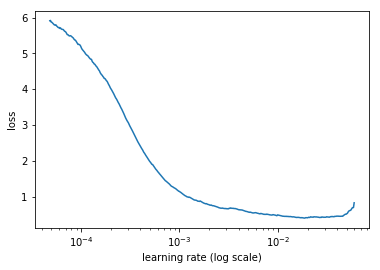

In [27]:
m.sched.plot(100)

### Sample - Execution

In [28]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [29]:
m.fit(lr, 3, metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe                   
    0      0.197107   0.170388   0.48455   
    1      0.152652   0.128444   0.440853                    
    2      0.111384   0.110014   0.388362                    


[array([0.11001]), 0.3883621872488658]

In [30]:
m.fit(lr, 5, metrics=[exp_rmspe], cycle_len=1)

epoch      trn_loss   val_loss   exp_rmspe                    
    0      0.091729   0.093653   0.330726  
    1      0.066498   0.089928   0.325367                     
    2      0.088979   0.089733   0.318065                     
    3      0.085906   0.085469   0.313643                     
    4      0.052443   0.083907   0.313183                     


[array([0.08391]), 0.31318310699144997]

In [ ]:
m.fit(lr, 2, metrics=[exp_rmspe], cycle_len=4)

### All

In [ ]:
### Recreate dataframe etc with full dataset

In [58]:
samp_size = n
joined_samp = joined.set_index("Date")

In [59]:
df, y, nas, mapper = proc_df(joined_samp, 'Sales', do_scale=True) # fast.ai method to normalise the dataframe, separate
                                                                  # the output variable.  Also returns the mapping
yl = np.log(y+10.0)

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)
y_range
# Note getting rid of the stores with no sales causes the value of y to become negative infinity.  Might need to
# change this in the next iteration

(0, 12.761901007825653)

In [60]:
# not needed if the sample has been run since this step has already been carried out
joined_test = joined_test.set_index("Date")

In [61]:
df_test, _, nas, mapper = proc_df(joined_test, 'Sales', do_scale=True,
                                  mapper=mapper, na_dict=nas)

In [62]:
train_ratio = 0.75
# train_ratio = 0.9
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))

### Test

In [69]:
df_temp=df_test.drop('Id', axis=1)

In [68]:
df_test.drop('Id', axis=1)

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,CompetitionDistance_na,CloudCover_na
Date,,,,,,,,,,,,,,,,,,,,,
2015-09-17,1,4,3,9,17,1,25,1,3,1,...,0.361056,0.272087,0.333411,0.079555,-1.183596,1.072424,1.273237,-0.466372,-0.05103,-0.292796
2015-09-17,3,4,3,9,17,1,25,26,1,1,...,2.395924,0.272087,0.245226,0.079555,-1.183596,1.072424,1.273237,-0.466372,-0.05103,-0.292796
2015-09-17,7,4,3,9,17,1,25,1,1,3,...,0.361056,-0.344777,-0.548435,0.079555,-1.183596,1.072424,1.273237,-0.466372,-0.05103,-0.292796
2015-09-17,8,4,3,9,17,1,12,1,1,1,...,0.361056,-0.344777,-0.548435,0.079555,-1.183596,1.072424,1.273237,-0.466372,-0.05103,-0.292796
2015-09-17,9,4,3,9,17,1,25,1,1,3,...,2.395924,0.272087,0.245226,0.079555,-1.183596,1.072424,1.273237,-0.466372,-0.05103,-0.292796
2015-09-17,10,4,3,9,17,1,25,1,1,1,...,2.904641,0.272087,0.421595,0.079555,-1.183596,1.072424,1.273237,-0.466372,-0.05103,-0.292796
2015-09-17,11,4,3,9,17,1,25,26,1,3,...,0.361056,-0.344777,-0.548435,0.079555,-1.183596,1.072424,1.273237,-0.466372,-0.05103,-0.292796
2015-09-17,12,4,3,9,17,1,1,26,1,3,...,0.361056,-0.344777,-0.548435,0.079555,-1.183596,1.072424,1.273237,-0.466372,-0.05103,-0.292796
2015-09-17,13,4,3,9,17,1,1,26,4,1,...,0.191483,0.272087,-0.283881,0.079555,-0.125296,1.072424,1.273237,-0.466372,-0.05103,-0.292796


In [71]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl.astype(np.float32), cat_flds=cat_vars, bs=128,
                                       test_df=df_temp)

In [30]:
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars]

In [31]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [73]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [74]:
m.fit(lr, 3, metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe                      
    0      0.072115   0.219563   0.248075  
    1      0.062412   0.216147   0.233064                       
    2      0.057714   0.229072   0.260232                       



[array([0.22907]), 0.26023163541839195]

In [76]:
m.fit(lr, 3, metrics=[exp_rmspe], cycle_len=1)

epoch      trn_loss   val_loss   exp_rmspe                      
    0      0.03646    0.213409   0.22276   
    1      0.028108   0.218679   0.223742                       
    2      0.026404   0.221144   0.219175                       



[array([0.22114]), 0.21917485440965187]

In [77]:
m.save('val_with_closed')

In [ ]:
m.load('val_with_closed')

In [78]:
x,y=m.predict_with_targs()

In [79]:
exp_rmspe(x,y)


 0.2751
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [80]:
df.shape, df_test.shape


((1017209, 40), (41088, 41))

In [44]:
df_test.head()


,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,Id,CompetitionDistance_na,CloudCover_na
Date,,,,,,,,,,,,,,,,,,,,,
2015-09-17,1,4,3,9,17,1,25,1,3,1,...,0.272087,0.333411,0.079555,-1.183596,1.072424,1.273237,-0.466372,1,-0.05103,-0.292796
2015-09-17,3,4,3,9,17,1,25,26,1,1,...,0.272087,0.245226,0.079555,-1.183596,1.072424,1.273237,-0.466372,2,-0.05103,-0.292796
2015-09-17,7,4,3,9,17,1,25,1,1,3,...,-0.344777,-0.548435,0.079555,-1.183596,1.072424,1.273237,-0.466372,3,-0.05103,-0.292796
2015-09-17,8,4,3,9,17,1,12,1,1,1,...,-0.344777,-0.548435,0.079555,-1.183596,1.072424,1.273237,-0.466372,4,-0.05103,-0.292796
2015-09-17,9,4,3,9,17,1,25,1,1,3,...,0.272087,0.245226,0.079555,-1.183596,1.072424,1.273237,-0.466372,5,-0.05103,-0.292796


In [45]:
df.head()

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,CompetitionDistance_na,CloudCover_na
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,3,7,31,1,25,1,3,1,...,-0.147662,-2.812232,1.744363,1.743047,0.644376,1.072424,1.273237,2.144211,-0.05103,-0.292796
2015-07-31,2,5,3,7,31,1,25,26,1,1,...,-0.147662,-0.961640,1.303440,1.743047,0.965073,1.072424,1.273237,2.144211,-0.05103,-0.292796
2015-07-31,3,5,3,7,31,1,25,26,1,1,...,-1.165096,-2.195368,1.832547,1.743047,0.644376,1.072424,1.273237,2.144211,-0.05103,-0.292796
2015-07-31,4,5,3,7,31,1,25,1,3,3,...,0.700200,0.272087,0.774333,1.743047,0.965073,1.072424,1.273237,2.144211,-0.05103,-0.292796
2015-07-31,5,5,3,7,31,1,4,1,1,1,...,-0.147662,-0.961640,1.479809,1.743047,0.644376,1.072424,1.273237,2.144211,-0.05103,-0.292796


In [81]:
pred_test=m.predict(True)

In [82]:
pred_test = np.exp(pred_test)

In [83]:
joined_test['Sales']=pred_test

In [84]:
csv_fn=f'{PATH}tmp/sub_with.csv'

In [85]:
joined_test[['Id','Sales']].to_csv(csv_fn, index=False)

In [88]:
joined_test_file=f'{PATH}joined_test'

In [86]:
FileLink(csv_fn)

/home/paperspace/projects/rossman/rossmann/tmp/sub_with.csv

In [89]:
FileLink(joined_test_file)

/home/paperspace/projects/rossman/rossmann/joined_test

In [ ]:
%qtconsole

## RF

In [14]:
from sklearn.ensemble import RandomForestRegressor

In [23]:
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, df.values, yl)

In [24]:
m = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
m.fit(trn, y_trn);

In [27]:
preds = m.predict(val)
m.score(trn, y_trn), m.score(val, y_val), m.oob_score_, exp_rmspe(preds, y_val)

(0.9975023256240658, 0.9544074757757447, 0.9915996856055498, 
  0.2783
 [torch.cuda.FloatTensor of size 1 (GPU 0)])

In [34]:
%qtconsole